# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

## Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv("/Users/paddy/Documents/Github/Dump-Truck/langchain-ac/.env")

True

In [2]:
# LLM
# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

# from langchain_deepseek import ChatDeepSeek
# llm = ChatDeepSeek(
#     model="deepseek/deepseek-chat-v3.1",
#     api_key=os.getenv("OPENROUTER_API_KEY"),
#     api_base="https://openrouter.ai/api/v1",
#     extra_body={"reasoning": {"enabled": True}},
# )

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

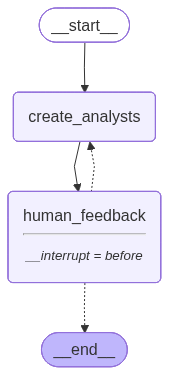

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [5]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on 

In [6]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [7]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0eb0c4-8a79-68ce-8002-5d23b7c6a613'}}

In [8]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph, emphasizing its scalability and integration capabilities with existing systems. She is motivated by the potential for LangGraph to enhance AI-driven solutions in various industries.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Data Science Research Group
Role: Data Analyst
Description: Mr. Liu analyzes the impact of LangGraph on data processing efficiency and accuracy. His work is driven by a desire to improve data-driven decision-making processes and to showcase how LangGraph can streamline workflows in data-intensive environments.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Strategy Consultants
Role: Business Development Analyst
Description: Ms. Thompson evaluates the business implications of adopting LangGraph, focusing on 

In [9]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0eb0c5-13f1-607a-8004-cfa7748bb45f'}}

In [10]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [11]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [12]:
final_state.next

()

In [13]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alice Johnson
Affiliation: Tech Innovators Inc.
Role: AI Researcher
Description: Alice focuses on the technical advantages of LangGraph, exploring its capabilities in enhancing AI model performance and integration. She is particularly interested in how LangGraph can streamline workflows and improve the efficiency of AI agents.
--------------------------------------------------
Name: Michael Chen
Affiliation: Startup Hub
Role: Entrepreneur
Description: Michael represents the startup perspective, emphasizing the potential of LangGraph to empower new businesses. He is keen on how adopting this framework can reduce development time and costs, allowing startups to innovate rapidly and compete effectively in the market.
--------------------------------------------------
Name: Dr. Sarah Patel
Affiliation: Data Science Institute
Role: Data Scientist
Description: Dr. Patel analyzes the data management and analytical benefits of LangGraph. She is concerned with how the framework can enhanc

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [14]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [15]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [16]:
# Web search tool
import warnings
warnings.filterwarnings('ignore', message='Field name.*shadows an attribute in parent')

from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3)

In [24]:
tavily_search.invoke({"query": "What is the news today - Jan 6th 2026?"})

{'query': 'What is the news today - Jan 6th 2026?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.detroitnews.com/story/news/politics/2026/01/06/capitol-riot-anniversary/88044017007/',
   'title': 'Fifth anniversary of the Jan. 6 attack brings fresh division to the Capitol',
   'content': 'Jan. 6, 2026, 8:08 a.m. ET. Hear this story. Rioters loyal to President Donald Trump rally at the U.S. Capitol in Washington, Jan. Washington',
   'score': 0.99926203,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=tCD9EpQeGwo',
   'title': '8AM Top Stories for Jan. 6, 2026 - YouTube',
   'content': "Tuesday morning's top Atlanta headlines include 3 people arrested for shooting of 3-year-old in a car; 4 adults arrested after a 5-year-old",
   'score': 0.9976586,
   'raw_content': None},
  {'url': 'https://www.cnn.com/2026/01/06/us/5-things-to-know-for-jan-6-capitol-riot-anniversary-nicolas-maduro-immigration-swiss-bar-fire-dual-ci

In [25]:
tavily_search.invoke("What is the news today - Jan 6th 2026?")

{'query': 'What is the news today - Jan 6th 2026?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.youtube.com/watch?v=tCD9EpQeGwo',
   'title': '8AM Top Stories for Jan. 6, 2026 - YouTube',
   'content': "Tuesday morning's top Atlanta headlines include 3 people arrested for shooting of 3-year-old in a car; 4 adults arrested after a 5-year-old",
   'score': 0.81630427,
   'raw_content': None},
  {'url': 'https://www.politico.com/news/2026/01/06/january-6-anniversary-donald-trump-00711324',
   'title': 'Back in power 5 years later, Trump has all but erased the ... - Politico',
   'content': "Back in power 5 years later, Trump has all but erased the stain of Jan. 6. In the years since the Capitol riot, Trump has learned it's nearly",
   'score': 0.7783298,
   'raw_content': None},
  {'url': 'https://www.cnn.com/2026/01/06/us/5-things-to-know-for-jan-6-capitol-riot-anniversary-nicolas-maduro-immigration-swiss-bar-fire-dual-citizenship',
   

In [17]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

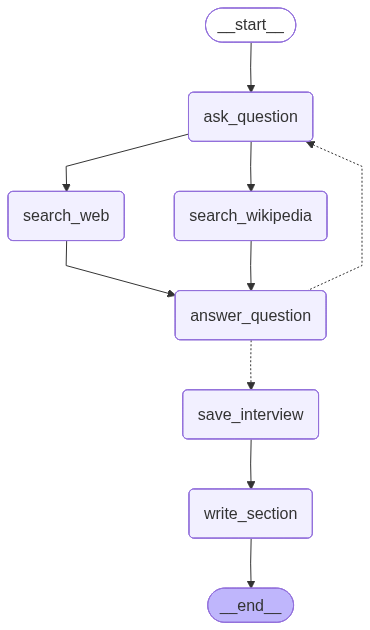

In [18]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [26]:
# Pick one analyst
analysts[0]

Analyst(affiliation='TechInsights', name='Alice Chen', role='Lead AI Researcher', description='Alice is a seasoned AI researcher with a focus on agent frameworks. She is interested in the technical aspects of LangGraph and its potential applications in various industries.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [19]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Unleashing the Power of LangGraph: Transforming AI Agent Development

### Summary
LangGraph has emerged as a groundbreaking framework for building sophisticated AI agents, offering developers a unique blend of flexibility and control that enhances AI model performance and integration. Launched nearly two years ago, LangGraph has already been adopted by major companies like LinkedIn, Uber, and Klarna to create production-ready agents. The framework distinguishes itself by allowing developers to choose from six core features as building blocks, enabling a tailored approach to agent development. This modularity is particularly beneficial for scenarios requiring human-in-the-loop interactions, where developers can easily implement features like interruption and resumption through simple function calls, such as `interrupt()` [1].

One of the most compelling aspects of LangGraph is its graph-based architecture, which models agent workflows as directed graphs. This design facilitates explicit state management and dynamic decision-making, allowing for complex, long-running workflows that traditional chain-based methods struggle to support [2]. The ability to manage state effectively is a cornerstone of LangGraph's architecture, providing significant advantages in error recovery and workflow execution [2]. 

Moreover, LangGraph's declarative API simplifies the definition of complex agent logic, making it accessible even for those new to AI development. Developers have reported that this approach strikes a balance between structured flows and the flexibility needed for dynamic agent behavior, enabling the reuse of components across various workflows [3]. The framework's integration with the broader LangChain ecosystem further enhances its capabilities, allowing for seamless interaction with other tools and APIs [4].

Interestingly, LangGraph is not just about building agents that generate content; it enables the creation of agents that can research, critique, and collaborate, mimicking high-performing teams [5]. This shift towards more intelligent, agentic applications reflects the growing demand for AI solutions that can handle complex tasks and adapt to changing conditions.

In summary, LangGraph represents a significant advancement in the development of AI agents, providing a robust framework that enhances efficiency and streamlines workflows. Its unique features and integration capabilities position it as a leading choice for developers looking to harness the full potential of AI technologies.

### Sources
[1] https://blog.langchain.com/building-langgraph/  
[2] https://mgx.dev/insights/langgraph-style-agent-graphs-fundamentals-advanced-patterns-features-and-future-directions/79417dacdf734afb986984fa2f1b692d  
[3] https://www.reddit.com/r/LLMDevs/comments/1jip6sm/why_we_chose_langgraph_to_build_our_coding_agent/  
[4] https://github.com/von-development/awesome-LangGraph  
[5] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

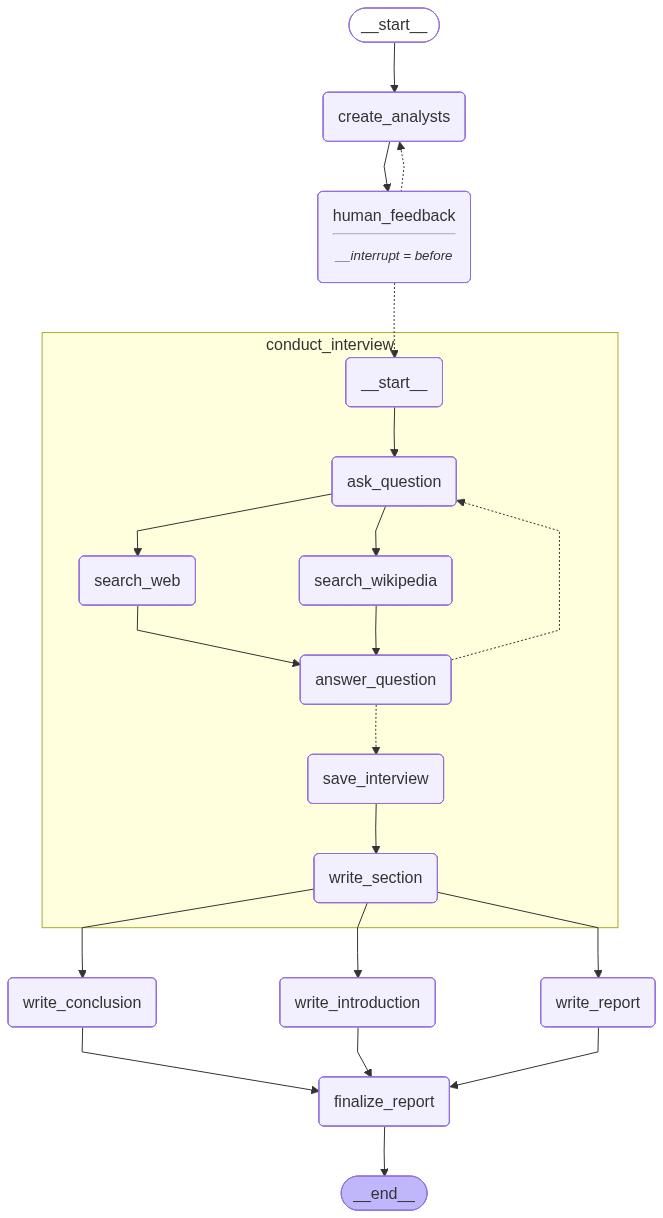

In [25]:
from langgraph.types import Send # updated in 1.0
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [26]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on understanding how LangGraph can enhance or compromise data security within an organization. He evaluates the framework's security features, potential vulnerabilities, and compliance with industry standards.
--------------------------------------------------
Name: Dr. Lisa Nguyen

In [27]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ad478-2e3b-6372-8002-87845d0b55a4'}}

In [28]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on understanding how LangGraph can enhance or compromise data security within an organization. He evaluates the framework's security features, potential vulnerabilities, and compliance with industry standards.
--------------------------------------------------
Name: Dr. Lisa Nguyen

In [29]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ad478-5521-6a86-8004-054b9bf88282'}}

In [30]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# LangGraph: Revolutionizing AI Agent Development

## Introduction

In the dynamic realm of AI development, LangGraph emerges as a transformative agent framework, offering unparalleled efficiency and capability enhancements. By adopting a graphical approach, LangGraph excels in managing complex, multi-step tasks, crucial for sophisticated AI agents. It integrates declarative and imperative APIs, supporting stateful, multi-agent applications with features like memory storage and fault tolerance. This framework not only reduces development time but also improves system quality, seamlessly integrating with large language models to enhance user experience. LangGraph's strategic advantages, including hybrid integration and open-source infrastructure, position it as a pivotal player in driving business growth and innovation across industries.

---



LangGraph emerges as a transformative agent framework in the AI landscape, offering significant benefits in enhancing AI efficiency, providing strategic advantages, and fostering business growth and innovation. Its graphical approach to constructing agent behaviors allows for the management of complex, multi-step tasks with backtracking and conditional branching, which is essential for developing sophisticated AI agents capable of operating autonomously and efficiently [1]. This graphical representation simplifies the design and implementation of complex workflows, reducing development time and improving system quality [4].

LangGraph's orchestration framework integrates both declarative and imperative APIs, supporting features such as short-term and long-term memory storage, human-in-the-loop processes, and fault tolerance. These capabilities are crucial for maintaining context and ensuring the reliability of AI workflows, making LangGraph a robust foundation for building stateful, multi-agent applications [2]. The framework's ability to integrate seamlessly with large language models (LLMs) further enhances its utility, enabling the creation of intelligent AI agents that can understand and generate human language, thus improving user experience and operational efficiency across various industries [5].

Strategically, LangGraph stands out for its ability to handle complex conditional logic and multi-step reasoning, making it ideal for applications requiring advanced state management and long-term system evolution. This positions LangGraph as a preferred choice for enterprises with experienced AI/ML engineers, supporting extended development cycles for sophisticated capabilities [2]. Its potential for hybrid integration with other frameworks allows organizations to create comprehensive, enterprise-ready AI solutions, facilitating gradual migration from existing implementations and risk mitigation through incremental adoption [2].

LangGraph's open-source nature and its foundation within the LangChain ecosystem enhance its appeal, providing a robust infrastructure for stateful agents and supporting integration with diverse data sources, APIs, and workflows. This flexibility and modularity make LangGraph not just a tool but a platform that others can build upon, enabling the deployment of multi-agent applications across a wide range of businesses [4].

In conclusion, LangGraph offers a unique set of tools and structures that empower businesses to harness the full potential of AI technologies. By integrating LangGraph into their operations, companies can enhance their product offerings, improve customer experiences, and maintain a competitive edge in the AI market. Its graphical approach, robust orchestration capabilities, and strategic advantages position LangGraph as a leading framework for optimizing AI systems' performance and driving innovation across industries.


---

## Conclusion

LangGraph emerges as a transformative agent framework in the AI landscape, offering significant advantages for optimizing AI systems. By employing a graphical approach, LangGraph enhances the efficiency and capability of AI models, particularly in managing complex, multi-step tasks. Its robust orchestration framework, integrating declarative and imperative APIs, supports stateful, multi-agent applications with features like memory storage and fault tolerance. This not only reduces development time but also improves system quality and operational efficiency. LangGraph's seamless integration with large language models further empowers businesses to innovate and maintain a competitive edge, making it a strategic asset for AI-driven growth and innovation.

## Sources
[1] https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
[2] https://blog.langchain.com/how-to-think-about-agent-frameworks/  
[3] https://blog.algoanalytics.com/2025/05/21/langgraph-the-framework-for-intelligent-ai-workflows/  
[4] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[5] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[6] https://artizen.com/insights/thought-leadership/ai-agent-frameworks  
[7] https://www.leanware.co/insights/langchain-vs-langgraph-comparison  
[8] https://interviewkickstart.com/blogs/articles/langgraph-for-retail-ai-agent  
[9] https://medium.com/@takafumi.endo/langchain-why-its-the-foundation-of-ai-agent-development-in-the-enterprise-era-f082717c56d3  
[10] https://www.scalablepath.com/machine-learning/langgrap

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r